In [1]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

In [2]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []
        
        self.batch_size = batch_size
        
    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype = np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]
        
        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches
    
    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)
        
    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []
        
        
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha, 
                 fc1_dims = 256, fc2_dims = 256, chkpt_dir='tmp/ppo'):
        super(ActorNetwork, self).__init__()
        
        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        
        self.actor = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        
        return dist
    
    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)
        
    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))
        
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims = 256, fc2_dims = 256, 
                chkpt_dir = 'tmp/ppo'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
                    nn.Linear(*input_dims, fc1_dims),
                    nn.ReLU(),
                    nn.Linear(fc1_dims, fc2_dims),
                    nn.ReLU(),
                    nn.Linear(fc2_dims, 1)
            )

        self.optimizer = optim.Adam(self.parameters(), lr = alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, state):
        value = self.critic(state)
        
        return value
    
    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)
        
    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))
        
        
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
                policy_clip=0.1, batch_size=64, N=2048, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        
        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
        
        
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)
        
    def save_models(self):
        print('saving models')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()
        
    def load_models(self):
        print('loading models')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()
        
    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        
        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()
        
        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()
        
        return action, probs, value
    
    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
                reward_arr, dones_arr, batches= self.memory.generate_batches()
            
            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)
            
            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                                    (1-int(dones_arr[k])) - values[k])
                    
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)
            
            values = T.tensor(values).to(self.actor.device)
            
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)
                
                dist = self.actor(states)
                critic_value = self.critic(states)
                
                critic_value = T.squeeze(critic_value)
                
                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip, 
                                                1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()
                
                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()
                
                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()
            
        self.memory.clear_memory()
        
        
    
                                            
                        

saving models
episode 0 score 11.0 avg score 11.0 time_steps 11 learning_steps 0
episode 1 score 10.0 avg score 10.5 time_steps 21 learning_steps 1
saving models
episode 2 score 19.0 avg score 13.3 time_steps 40 learning_steps 2
saving models
episode 3 score 19.0 avg score 14.8 time_steps 59 learning_steps 2
saving models
episode 4 score 21.0 avg score 16.0 time_steps 80 learning_steps 4
saving models
episode 5 score 68.0 avg score 24.7 time_steps 148 learning_steps 7
episode 6 score 24.0 avg score 24.6 time_steps 172 learning_steps 8
saving models
episode 7 score 38.0 avg score 26.2 time_steps 210 learning_steps 10
saving models
episode 8 score 37.0 avg score 27.4 time_steps 247 learning_steps 12
saving models
episode 9 score 32.0 avg score 27.9 time_steps 279 learning_steps 13
saving models
episode 10 score 65.0 avg score 31.3 time_steps 344 learning_steps 17
episode 11 score 19.0 avg score 30.2 time_steps 363 learning_steps 18
episode 12 score 41.0 avg score 31.1 time_steps 404 lear

saving models
episode 103 score 200.0 avg score 110.9 time_steps 11153 learning_steps 557
saving models
episode 104 score 200.0 avg score 112.7 time_steps 11353 learning_steps 567
saving models
episode 105 score 200.0 avg score 114.0 time_steps 11553 learning_steps 577
saving models
episode 106 score 179.0 avg score 115.6 time_steps 11732 learning_steps 586
saving models
episode 107 score 200.0 avg score 117.2 time_steps 11932 learning_steps 596
saving models
episode 108 score 200.0 avg score 118.8 time_steps 12132 learning_steps 606
saving models
episode 109 score 200.0 avg score 120.5 time_steps 12332 learning_steps 616
saving models
episode 110 score 170.0 avg score 121.6 time_steps 12502 learning_steps 625
saving models
episode 111 score 200.0 avg score 123.4 time_steps 12702 learning_steps 635
saving models
episode 112 score 123.0 avg score 124.2 time_steps 12825 learning_steps 641
saving models
episode 113 score 138.0 avg score 124.8 time_steps 12963 learning_steps 648
saving mod

episode 197 score 200.0 avg score 185.7 time_steps 28531 learning_steps 1426
episode 198 score 200.0 avg score 185.7 time_steps 28731 learning_steps 1436
episode 199 score 200.0 avg score 185.7 time_steps 28931 learning_steps 1446
saving models
episode 200 score 200.0 avg score 185.8 time_steps 29131 learning_steps 1456
episode 201 score 200.0 avg score 185.8 time_steps 29331 learning_steps 1466
episode 202 score 200.0 avg score 185.8 time_steps 29531 learning_steps 1476
episode 203 score 200.0 avg score 185.8 time_steps 29731 learning_steps 1486
episode 204 score 200.0 avg score 185.8 time_steps 29931 learning_steps 1496
episode 205 score 200.0 avg score 185.8 time_steps 30131 learning_steps 1506
saving models
episode 206 score 200.0 avg score 186.0 time_steps 30331 learning_steps 1516
episode 207 score 200.0 avg score 186.0 time_steps 30531 learning_steps 1526
episode 208 score 200.0 avg score 186.0 time_steps 30731 learning_steps 1536
episode 209 score 200.0 avg score 186.0 time_ste

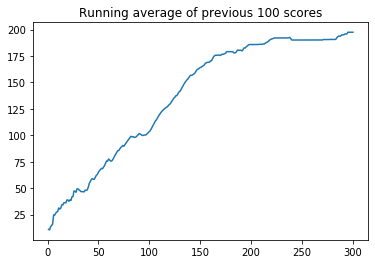

In [5]:
import gym
import numpy as np
from utils import plot_learning_curve

env = gym.make('CartPole-v0')
N = 20
batch_size = 5
n_epochs = 4
alpha = 0.0003
agent = Agent(n_actions=env.action_space.n, batch_size = batch_size,
             alpha = alpha, n_epochs = n_epochs, 
              input_dims = env.observation_space.shape)

n_games = 300

figure_file = 'plots/cartpole.png'

best_score = env.reward_range[0]
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0

for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0 
    while not done:
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        n_steps += 1
        score += reward
        agent.remember(observation, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters += 1
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        agent.save_models()

    print('episode', i, 'score %.1f' %score, 'avg score %.1f' %avg_score, 
          'time_steps', n_steps, 'learning_steps', learn_iters)
        
x = [i+1 for i in range(len(score_history))]
plot_learning_curve(x, score_history, figure_file)


